# NSW Air Quality Monthly Averages 2000 - 2024 | Processing

The main tasks completed to clean and preprocess this dataset were:

**Data Cleaning**
1. Drop columns with data from irrelevant Air Quality Research Sites 
2. Drop empty columns.

**Handle Outliers**

**Handle Missing Data**
1. Drop columns with insufficient data quantity
2. Fill missing values.

**Data Normalization**
1. Restructure the table into a more useful format.
2. Change capitalization of 'suburb' data.
3. Add Local Health District data to the table.
4. Reformat date column to track only year-month.
5. Sort by date.

**Set Time Intervals**


## Set Up

Ensure that the required libraries are available by running the below code in the terminal before execution:
- pip install pandas


Execute the following in the jupyter notebook before execution to ensure that the required libraries are imported:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

## Load Datasets

In [2]:
# Read files.
df_air_quality = pd.read_excel('data-raw.xlsx')
df_geography = pd.read_csv('../1-nsw-geography/data-processed.csv')

## Data Cleaning

Drop columns with data from irrelevant Air Quality Research Sites.

In [3]:
# Track the number of columns before dropping.
initial_columns = df_air_quality.shape[1]

# Drop irrelevant columns.
df_air_quality = df_air_quality.drop(columns=[col for col in df_air_quality.columns if 'LIVERPOOL SWAQS' in col or 'RRPOD2' in col])

# Track the number of columns after dropping.
final_columns = df_air_quality.shape[1]

# Calculate the number of columns dropped.
columns_dropped = initial_columns - final_columns
print(f"Number of columns dropped: {columns_dropped}")

Number of columns dropped: 5


Drop columns with no data.

In [4]:
# Track the number of columns before dropping.
initial_columns = df_air_quality.shape[1]

# Remove empty columns.
df_air_quality = df_air_quality.dropna(axis=1, how='all')

# Track the number of columns after dropping.
final_columns = df_air_quality.shape[1]

# Calculate the number of columns dropped.
columns_dropped = initial_columns - final_columns
print(f"Number of columns dropped: {columns_dropped}")

Number of columns dropped: 18


## Handle Missing Data

Set threshold for excluding data.

In [5]:
threshold = 0.5

## E.g.,
# 0 = no columns are excluded.
# 0.2 = 20% of data must be collected.
# 0.5 = 50% of data must be collected.
# 0.8 = 80% of data must be collected.
# 1.0 = 100% of data must be collected.

Drop columns with insufficient data quantity.

In [6]:
# Track the number of columns before dropping.
initial_columns = df_air_quality.shape[1]

# Drop columns with insufficient quantity of data.
if (threshold > 0 and threshold < 1):
    df_air_quality = df_air_quality.dropna(thresh=len(df_air_quality) * threshold, axis=1)

# Track the number of columns after dropping.
final_columns = df_air_quality.shape[1]

# Calculate the number of columns dropped.
columns_dropped = initial_columns - final_columns
print(f"Number of columns dropped: {columns_dropped}")

Number of columns dropped: 132


Fill missing values.

In [7]:
# Set fill method
method = "mean"

# Get columns to fill
columns_to_fill = df_air_quality.columns[df_air_quality.isnull().any()]


###
###
### No idea if these all work...
###
###

# Mean: fill missing values with the mean of the column
if (method == "mean"):
    for column in columns_to_fill:
        df_air_quality[column].fillna(df_air_quality[column].mean(), inplace=True)

# Median: fill missing values with the median of the column
if (method == "median"):
    for column in columns_to_fill:
        df_air_quality[column].fillna(df_air_quality[column].median(), inplace=True)

# Mode: fill missing values with the mode of the column
if (method == "mode"):
    for column in columns_to_fill:
        df_air_quality[column].fillna(df_air_quality[column].mode()[0], inplace=True)

# ffill: fill missing values with the last known value
if (method == "ffill"):
    for column in columns_to_fill:
        df_air_quality[column].fillna(method='ffill', inplace=True)

# bfill: fill missing values with the next known value
if (method == "bfill"):
    for column in columns_to_fill:
        df_air_quality[column].fillna(method='bfill', inplace=True)

# constant: fill missing values with a constant value
if (method == "constant"):
    for column in columns_to_fill:
        df_air_quality[column].fillna(0, inplace=True)

# interpolate-linear: fill missing values with an interpolated value
if (method == "interpolate-linear"):
    for column in columns_to_fill:
        df_air_quality[column].interpolate(method='linear', inplace=True)

# interpolate-polynomial: fill missing values with an interpolated value
if (method == "interpolate-polynomial"):
    for column in columns_to_fill:
        df_air_quality[column].interpolate(method='polynomial', order=2, inplace=True)

# drop: drop rows with missing values
if (method == "drop"):
    for column in columns_to_fill:
        df_air_quality[column].dropna(inplace=True)

C:\Users\matth\AppData\Local\Temp\ipykernel_4692\1698824177.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_air_quality[column].fillna(df_air_quality[column].mean(), inplace=True)


## Handle Outliers

Remove outliers.

In [8]:
# Calculate Z-scores for each column
z_scores = stats.zscore(df_air_quality.select_dtypes(include=['float64']))

# Create a boolean mask for rows where all Z-scores are less than 3 (i.e., not outliers)
mask = (abs(z_scores) < 3).all(axis=1)

# Apply the mask to the DataFrame to remove outliers
df_air_quality = df_air_quality[mask]

## Data Normalization

Restructure the Air Quality data.

In [9]:
# Melt the DataFrame to long format
df_melted = df_air_quality.melt(id_vars=['Date'], var_name='variable', value_name='monthly average')

# Extract 'suburb', 'pollutant', and 'measure' from the 'variable' column
df_melted[['suburb', 'pollutant', 'measure']] = df_melted['variable'].str.extract(r'((?:\w+\s?){1,3}) (.+?) monthly average \[(.+?)\]')

# Drop the original 'variable' column
df_melted = df_melted.drop(columns=['variable'])

# Rename 'Date' column to 'date'
df_melted = df_melted.rename(columns={'Date': 'date'})

# Reorder the columns
df_melted = df_melted[['date', 'suburb', 'pollutant', 'measure', 'monthly average']]

# Reassign the melted data to the original DataFrame
df_air_quality = df_melted

# Merge on 'date' and 'suburb'
df_air_quality = df_air_quality.merge(df_geography, on='suburb', how='left')

# Pivot the table to have pollutants and measures as columns
pollutant_measure_headers = df_air_quality.pivot_table(index=['date', 'suburb'], columns=['pollutant', 'measure'], values='monthly average')

# Flatten the MultiIndex columns
pollutant_measure_headers.columns = [f'{pollutant} {measure}' for pollutant, measure in pollutant_measure_headers.columns]

# Reset the index to turn 'date' and 'suburb' back into columns
df_air_quality = pollutant_measure_headers.reset_index()

# Display the restructured DataFrame
df_air_quality.head()

,date,suburb,CO ppm,NO pphm,NO2 pphm,OZONE pphm,PM10 µg/m³,SO2 pphm
0,28/02/2001,ALBION PARK SOUTH,NaN,0.112676,0.35446,1.933028,NaN,0.065116
1,28/02/2001,ALBURY,NaN,NaN,NaN,NaN,17.348649,NaN
2,28/02/2001,BARGO,NaN,0.400000,0.50000,1.900000,14.519886,0.000000
3,28/02/2001,BERESFIELD,NaN,0.600000,0.70000,1.700000,19.200000,0.148188
4,28/02/2001,BRINGELLY,NaN,0.300000,0.60000,1.900000,18.400000,0.100000


Change capitalization of 'suburb' data.

In [10]:
# Capitalize the first letter of each word in the 'suburb' column
df_air_quality['suburb'] = df_air_quality['suburb'].str.title()

# Display the updated DataFrame
df_air_quality.head()

,date,suburb,CO ppm,NO pphm,NO2 pphm,OZONE pphm,PM10 µg/m³,SO2 pphm
0,28/02/2001,Albion Park South,NaN,0.112676,0.35446,1.933028,NaN,0.065116
1,28/02/2001,Albury,NaN,NaN,NaN,NaN,17.348649,NaN
2,28/02/2001,Bargo,NaN,0.400000,0.50000,1.900000,14.519886,0.000000
3,28/02/2001,Beresfield,NaN,0.600000,0.70000,1.700000,19.200000,0.148188
4,28/02/2001,Bringelly,NaN,0.300000,0.60000,1.900000,18.400000,0.100000


Add Local Health District data to the table.

In [11]:
# Merge df_air_quality with df_geography to add 'lhd' column based on 'suburb'
df_air_quality = df_air_quality.merge(df_geography, on='suburb', how='left')

# Reorder columns to place 'lhd' as the third column
cols = df_air_quality.columns.tolist()
cols.insert(2, cols.pop(cols.index('lhd')))
df_air_quality = df_air_quality[cols]

# Display the updated DataFrame
df_air_quality.head()

,date,suburb,lhd,CO ppm,NO pphm,NO2 pphm,OZONE pphm,PM10 µg/m³,SO2 pphm
0,28/02/2001,Albion Park South,Murrumbidgee,NaN,0.112676,0.35446,1.933028,NaN,0.065116
1,28/02/2001,Albury,NaN,NaN,NaN,NaN,NaN,17.348649,NaN
2,28/02/2001,Bargo,South Western Sydney,NaN,0.400000,0.50000,1.900000,14.519886,0.000000
3,28/02/2001,Beresfield,Hunter New England,NaN,0.600000,0.70000,1.700000,19.200000,0.148188
4,28/02/2001,Bringelly,South Western Sydney,NaN,0.300000,0.60000,1.900000,18.400000,0.100000


Aggregate columns based on Local Health District.

In [12]:
# Extract pollutant columns to be averaged
pollutants = df_air_quality.columns[3:]

# Combine rows where 'date' and 'lhd' match by averaging th pollutant values.
df_air_quality = df_air_quality.groupby(['date', 'lhd'], as_index=False).agg({col: 'mean' for col in pollutants})

# Display the updated DataFrame
df_air_quality.head()

,date,lhd,CO ppm,NO pphm,NO2 pphm,OZONE pphm,PM10 µg/m³,SO2 pphm
0,28/02/2001,Hunter New England,0.2,0.544229,0.636079,1.800000,18.192000,0.148948
1,28/02/2001,Illawarra Shoalhaven,0.2,0.450000,0.750000,1.600000,21.803734,0.200000
2,28/02/2001,Murrumbidgee,NaN,0.112676,0.354460,1.933028,NaN,0.065116
3,28/02/2001,Nepean Blue Mountains,NaN,0.200000,0.650000,1.900000,18.350000,0.050000
4,28/02/2001,Northern Sydney,NaN,0.500000,0.700000,1.500000,17.200000,0.100000


Reformat date so make data sortable by month.

In [13]:
# Convert the 'date' column to datetime format
df_air_quality['date'] = pd.to_datetime(df_air_quality['date'], format='%d/%m/%Y')

# Extract year and month from the 'date' column and drop the 'day'
df_air_quality['year_month'] = df_air_quality['date'].dt.to_period('M')

# Drop the original 'date' column
df_air_quality = df_air_quality.drop(columns=['date'])

# Rename 'year_month' to 'date' to keep the column name consistent
df_air_quality = df_air_quality.rename(columns={'year_month': 'date'})

# Reorder columns to place 'date' as the first column
cols = df_air_quality.columns.tolist()
cols.insert(0, cols.pop(cols.index('date')))
df_air_quality = df_air_quality[cols]

# Display the updated DataFrame
df_air_quality.head()

,date,lhd,CO ppm,NO pphm,NO2 pphm,OZONE pphm,PM10 µg/m³,SO2 pphm
0,2001-02,Hunter New England,0.2,0.544229,0.636079,1.800000,18.192000,0.148948
1,2001-02,Illawarra Shoalhaven,0.2,0.450000,0.750000,1.600000,21.803734,0.200000
2,2001-02,Murrumbidgee,NaN,0.112676,0.354460,1.933028,NaN,0.065116
3,2001-02,Nepean Blue Mountains,NaN,0.200000,0.650000,1.900000,18.350000,0.050000
4,2001-02,Northern Sydney,NaN,0.500000,0.700000,1.500000,17.200000,0.100000


Sort by date.

In [14]:
# Sort the DataFrame by the 'date' column
df_air_quality = df_air_quality.sort_values(by=['lhd', 'date'])

# Display the sorted DataFrame
df_air_quality.head()

,date,lhd,CO ppm,NO pphm,NO2 pphm,OZONE pphm,PM10 µg/m³,SO2 pphm
945,2000-03,Hunter New England,0.4,0.684229,0.796079,1.505833,18.327849,0.17931
468,2000-09,Hunter New England,0.3,0.824229,0.956079,2.000000,20.132153,0.15931
1548,2000-10,Hunter New England,0.2,0.624229,0.856079,2.005833,18.907153,0.11931
648,2000-11,Hunter New England,0.2,0.564229,0.676079,1.866667,15.967000,0.13931
1728,2000-12,Hunter New England,0.2,0.504229,0.696079,2.133333,18.967000,0.13931


## Set Time Intervals

Create a new dataset with data aggregated for each financial year.

In [15]:
# Create monthly and financial year data frames.
df_monthly = df_air_quality.copy()
df_financial_year = df_air_quality.copy()

Convert months to financial year.

In [16]:
# Extract year and month from the 'date' column
df_financial_year['year'] = df_financial_year['date'].dt.year
df_financial_year['month'] = df_financial_year['date'].dt.month

# Append a new column called financial year
df_financial_year.insert(0, 'financial year', None)

# Assign financial year based on month
for row in df_financial_year.itertuples():
    if row.month < 7:
        df_financial_year.loc[row.Index, 'financial year'] = f"{row.year - 1}/{row.year}"
    else:
        df_financial_year.loc[row.Index, 'financial year'] = f"{row.year}/{row.year + 1}"

# Drop date and temporary columns
df_financial_year = df_financial_year.drop(columns=['date', 'year', 'month'])

# Aggregate the data by financial year and LHD
df_financial_year = df_financial_year.groupby(['financial year', 'lhd']).mean().reset_index()

# Drop first and last financial years as they are incomplete.
df_financial_year = df_financial_year[~df_financial_year['financial year'].isin(['1999/2000', '2024/2025'])]

# Display the financial year data.
df_financial_year.head()

,financial year,lhd,CO ppm,NO pphm,NO2 pphm,OZONE pphm,PM10 µg/m³,SO2 pphm
9,2000/2001,Hunter New England,0.225,0.658545,0.774551,1.817396,18.473913,0.147924
10,2000/2001,Illawarra Shoalhaven,0.225,0.525000,0.787500,1.850000,20.091234,0.125000
11,2000/2001,Murrumbidgee,NaN,0.112676,0.354460,1.933028,NaN,0.065116
12,2000/2001,Nepean Blue Mountains,NaN,0.243750,0.668750,1.975000,17.033688,0.069175
13,2000/2001,Northern Sydney,NaN,0.637500,0.912500,1.665513,15.675000,0.100000


## Output Processed Dataset

In [17]:
# File path.
file_path_output_monthly = 'data-processed-monthly.csv'
file_path_output_financial_year = 'data-processed-financial-year.csv'

# Save the file.
df_monthly.to_csv(file_path_output_monthly, index=False)
df_financial_year.to_csv(file_path_output_financial_year, index=False)

## View Dataset (Monthly)

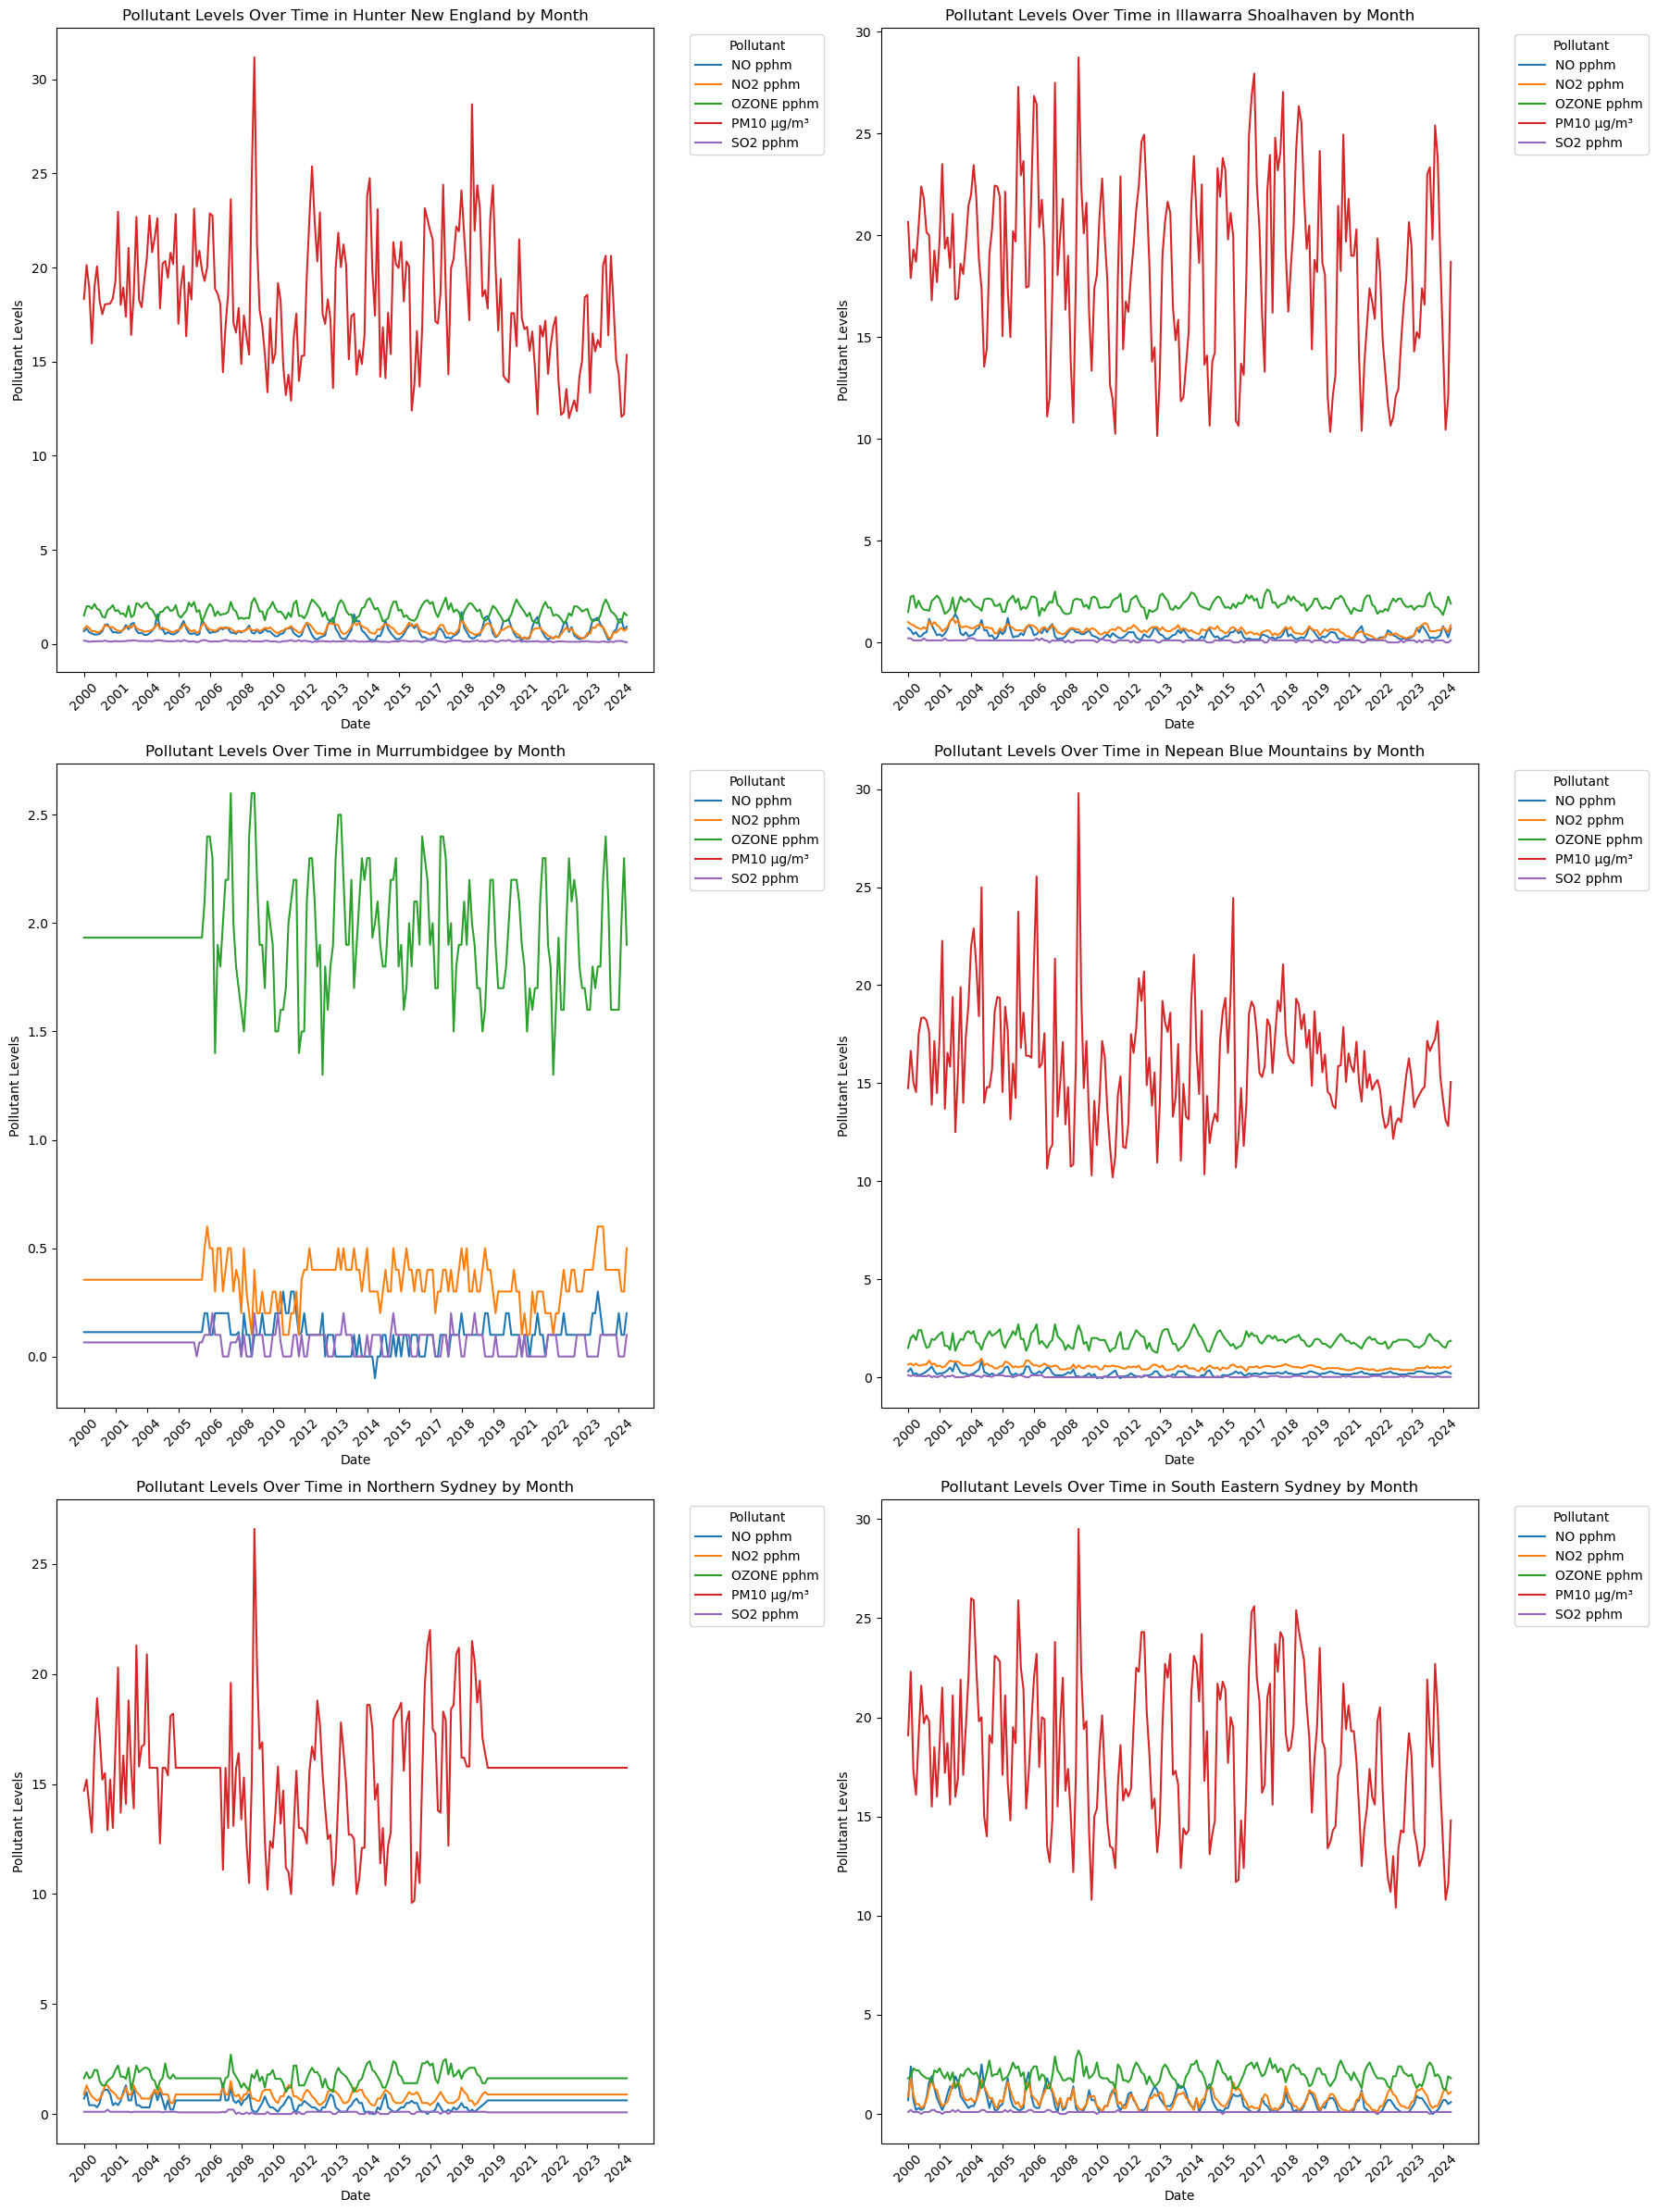

In [18]:
# Set the figure size
fig, axes = plt.subplots(3, 2, figsize=(18, 24))

# List of pollutants to plot
pollutants = ['NO pphm', 'NO2 pphm', 'OZONE pphm', 'PM10 µg/m³', 'SO2 pphm']

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each LHD
for i, lhd in enumerate(df_monthly['lhd'].unique()):
    if i >= len(axes):
        break
    ax = axes[i]
    subset = df_monthly[df_monthly['lhd'] == lhd]
    for pollutant in pollutants:
        ax.plot(subset['date'].astype(str), subset[pollutant], label=pollutant)
    
    ax.set_title(f'Pollutant Levels Over Time in {lhd} by Month')
    ax.set_xlabel('Date')
    ax.set_xticks(ticks=range(0, len(subset['date']), 12))
    ax.set_xticklabels(subset['date'].dt.year[::12], rotation=45)
    ax.set_ylabel('Pollutant Levels')
    ax.legend(title='Pollutant', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## View Dataset (Financial Year)

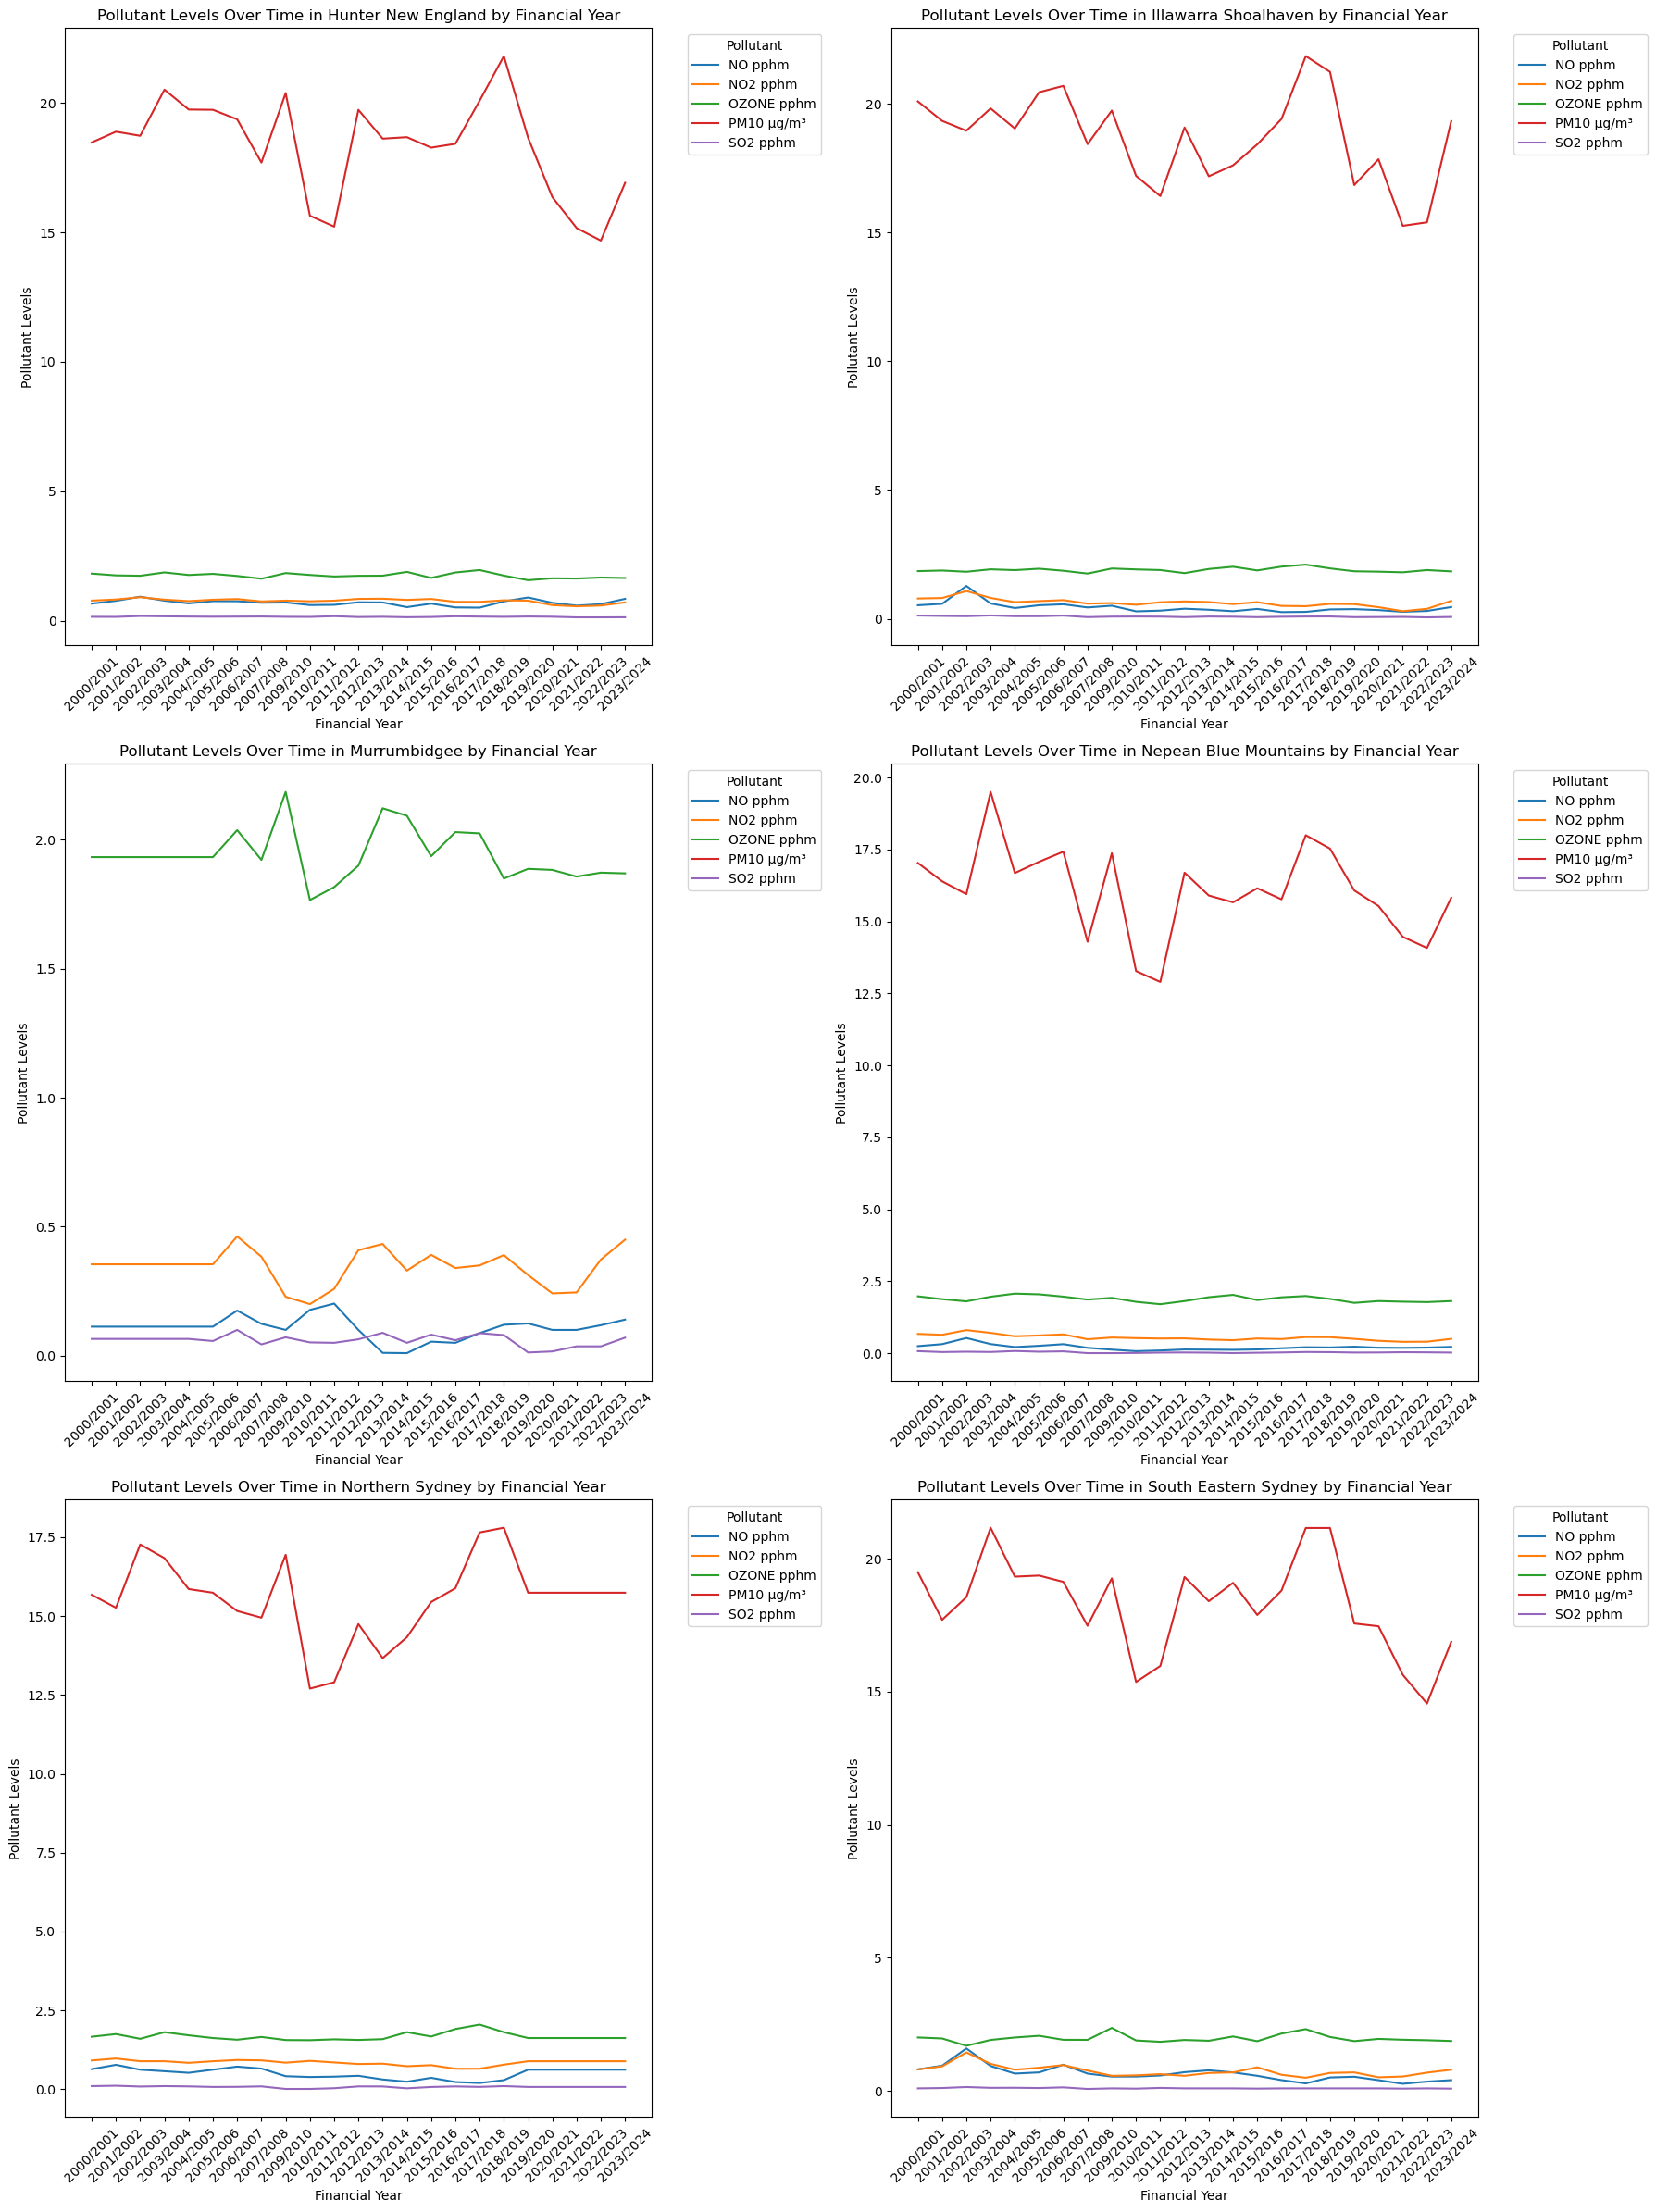

In [19]:
# Set the figure size
fig, axes = plt.subplots(3, 2, figsize=(18, 24))

# List of pollutants to plot
pollutants = ['NO pphm', 'NO2 pphm', 'OZONE pphm', 'PM10 µg/m³', 'SO2 pphm']

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each LHD
for i, lhd in enumerate(df_financial_year['lhd'].unique()):
    if i >= len(axes):
        break
    ax = axes[i]
    subset = df_financial_year[df_financial_year['lhd'] == lhd]
    for pollutant in pollutants:
        ax.plot(subset['financial year'].astype(str), subset[pollutant], label=pollutant)
    
    ax.set_title(f'Pollutant Levels Over Time in {lhd} by Financial Year')
    ax.set_xlabel('Financial Year')
    ax.set_ylabel('Pollutant Levels')
    ax.legend(title='Pollutant', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()